*Image Binary Classification using CNN*

Reference: https://towardsdatascience.com/pytorch-vision-binary-image-classification-d9a227705cf9

In [2]:
import torch
from torchvision import transforms, datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cuda


In [3]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])
}

new_dataset = datasets.ImageFolder(root='./flower', transform=image_transforms["train"])

new_dataset

Dataset ImageFolder
    Number of datapoints: 110
    Root location: ./flower
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [5]:
idx2class = {v: k for k, v in new_dataset.class_to_idx.items()}
idx2class

{0: 'Lupinus polyphyllus', 1: 'Viola cornuta'}

In [6]:
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler

new_dataset_size = len(new_dataset)
new_dataset_size_indices = list(range(new_dataset_size))
np.random.shuffle(new_dataset_size_indices)
val_split_index = int(np.floor(0.2 * new_dataset_size))  # 80% train, 20% validation
train_idx, val_idx = new_dataset_size_indices[val_split_index:], new_dataset_size_indices[:val_split_index]
# train_idx, val_idx = new_dataset_size_indices[:1000], new_dataset_size_indices[1000:1200]
train_loader = DataLoader(dataset=new_dataset, shuffle=False, batch_size=8, sampler=SubsetRandomSampler(train_idx))
val_loader = DataLoader(dataset=new_dataset, shuffle=False, batch_size=1, sampler=SubsetRandomSampler(val_idx))

(torch.Size([8, 3, 128, 128]),
 tensor([1, 0, 0, 0, 0, 0, 1, 0]),
 torch.Size([3, 128, 128]))

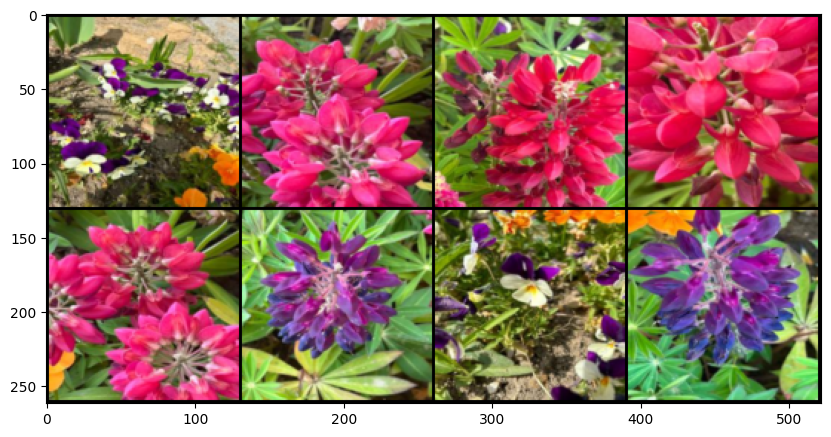

In [7]:
import matplotlib.pyplot as plt
from torchvision import utils

single_batch = next(iter(train_loader))
single_image = single_batch[0][0]
# plt.imshow(single_image.permute(1, 2, 0))  # single image
single_batch_grid = utils.make_grid(single_batch[0], nrow=4)
plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1, 2, 0))
single_batch[0].shape, single_batch[1], single_image.shape

In [31]:
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm


class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 256, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 2, kernel_size=32)  # output channel is 2 (binary)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # this makes size half
        
    def forward(self, x):
        # (3, 128, 128)
        x = self.conv1(x)
        # (256, 128, 128)
        x = self.pool(x)
        # (256, 64, 64)
        
        x = self.conv2(x)
        # (128, 64, 64)
        x = self.conv3(x)
        # (64, 64, 64)
        x = self.pool(x)
        # (64, 32, 32)
        
        x = self.conv4(x)
        # (2, 1, 1)
        return x


model = BinaryClassifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_tag, dim=1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

def train(model, device, criterion, optimizer, epoch):
    accuracy_stats = {'train': [], 'val': []}
    loss_stats = {'train': [], 'val': []}
    
    for e in tqdm(range(1, epoch+1)):
        # training
        train_epoch_loss = 0
        train_epoch_acc = 0
        
        model.train()
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            optimizer.zero_grad()
            
            y_train_pred = model(X_train_batch).squeeze()
            
            train_loss = criterion(y_train_pred, y_train_batch)
            train_acc = binary_acc(y_train_pred, y_train_batch)
            
            train_loss.backward()
            optimizer.step()
            
            train_epoch_loss += train_loss.item()
            train_epoch_acc += train_acc.item()
    
        # validation
        with torch.no_grad():
            model.eval()
            val_epoch_loss = 0
            val_epoch_acc = 0
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                y_val_pred = model(X_val_batch).squeeze()
                y_val_pred = torch.unsqueeze(y_val_pred, 0)
                val_loss = criterion(y_val_pred, y_val_batch)
                val_acc = binary_acc(y_val_pred, y_val_batch)
                val_epoch_loss += val_loss.item()
                val_epoch_acc += val_acc.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))
        accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
        accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
        print(f'Epoch {e}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    
    return accuracy_stats, loss_stats

accuracy_stats, loss_stats = train(model, device, criterion, optimizer, epoch=20)

BinaryClassifier(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 2, kernel_size=(32, 32), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: | Train Loss: 6.34270 | Val Loss: 2.54615 | Train Acc: 54.545| Val Acc: 40.909
Epoch 2: | Train Loss: 0.82557 | Val Loss: 0.29557 | Train Acc: 84.182| Val Acc: 95.455
Epoch 3: | Train Loss: 0.62340 | Val Loss: 0.15245 | Train Acc: 94.455| Val Acc: 95.455
Epoch 4: | Train Loss: 0.09440 | Val Loss: 1.42909 | Train Acc: 96.727| Val Acc: 86.364
Epoch 5: | Train Loss: 0.15759 | Val Loss: 0.29152 | Train Acc: 95.636| Val Acc: 95.455
Epoch 6: | Train Loss: 0.00178 | Val Loss: 0.07181 | Train Acc: 100.000| Val Acc: 95.455
Epoch 7: | Train Loss: 0.00228 | Val Loss: 0.03126 | Train Acc: 100.000| Val Acc: 100.000
Epoch 8: | Train Loss: 0.00133 | Val Loss: 0.03881 | Train Acc: 100.000| Val Acc: 95.455
Epoch 9: | Train Loss: 0.00024 | Val Loss: 0.03796 | Train Acc: 100.000| Val Acc: 95.455
Epoch 10: | Train Loss: 0.00013 | Val Loss: 0.04022 | Train Acc: 100.000| Val Acc: 95.455
Epoch 11: | Train Loss: 0.00010 | Val Loss: 0.04077 | Train Acc: 100.000| Val Acc: 95.455
Epoch 12: | Train Loss:

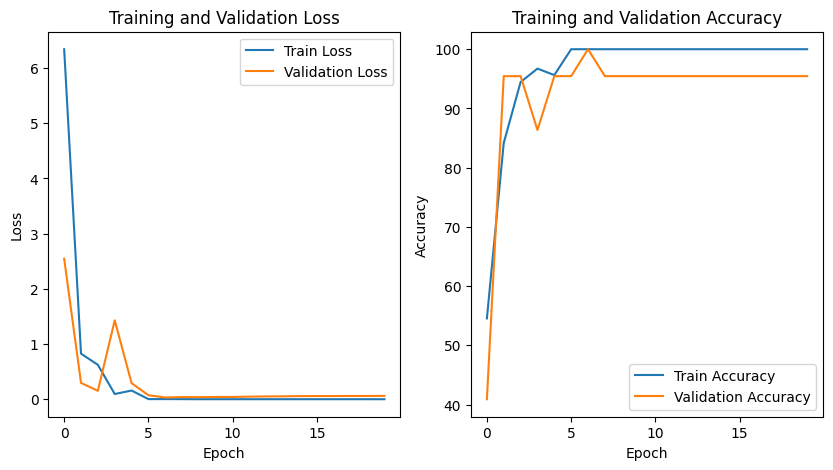

In [32]:
# Loss and Accuracy Visualization
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_stats['train'], label='Train Loss')
plt.plot(loss_stats['val'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_stats['train'], label='Train Accuracy')
plt.plot(accuracy_stats['val'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [33]:
torch.save(model, 'flower.pt')

In [34]:
from PIL import Image

model2 = torch.load('flower.pt').to(device)

for answer in [0, 1]:
    category = 'Lupinus polyphyllus' if answer == 0 else 'Viola cornuta'
    for i in range(20):
        test_img = Image.open(f'./flower/{category}/{i}.jpg')
        x = image_transforms['test'](test_img)
        x.unsqueeze(0)
        x = x.to(device)
        
        prediction = model2(x).argmax()
        print(i, answer, prediction)

0 0 tensor(0, device='cuda:0')
1 0 tensor(0, device='cuda:0')
2 0 tensor(0, device='cuda:0')
3 0 tensor(0, device='cuda:0')
4 0 tensor(0, device='cuda:0')
5 0 tensor(0, device='cuda:0')
6 0 tensor(0, device='cuda:0')
7 0 tensor(0, device='cuda:0')
8 0 tensor(0, device='cuda:0')
9 0 tensor(0, device='cuda:0')
10 0 tensor(0, device='cuda:0')
11 0 tensor(0, device='cuda:0')
12 0 tensor(0, device='cuda:0')
13 0 tensor(0, device='cuda:0')
14 0 tensor(0, device='cuda:0')
15 0 tensor(0, device='cuda:0')
16 0 tensor(0, device='cuda:0')
17 0 tensor(0, device='cuda:0')
18 0 tensor(0, device='cuda:0')
19 0 tensor(0, device='cuda:0')
0 1 tensor(1, device='cuda:0')
1 1 tensor(1, device='cuda:0')
2 1 tensor(1, device='cuda:0')
3 1 tensor(1, device='cuda:0')
4 1 tensor(1, device='cuda:0')
5 1 tensor(1, device='cuda:0')
6 1 tensor(1, device='cuda:0')
7 1 tensor(1, device='cuda:0')
8 1 tensor(1, device='cuda:0')
9 1 tensor(1, device='cuda:0')
10 1 tensor(1, device='cuda:0')
11 1 tensor(1, device='cuda: